### **Install Required Packages**

In [ ]:
!pip install faiss-cpu sentence-transformers biopython transformers torch spacy scispacy tqdm numpy pandas matplotlib seaborn

  Using cached faiss_cpu-1.11.0-cp310-cp310-manylinux_2_28_x86_64.whl (31.3 MB)
  Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
  Using cached biopython-1.85-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)


### **Install Biomedical NLP Models for Spacy**

In [2]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 1.1 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Using cached spacy-3.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached langcodes-3.5.0-py3-none-any.whl (182 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.7 MB/s eta 0:00:0000:0100:01
  Using cached murmurhash-1.0.12-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (124 kB)
  Using cached pathy-0.11.0-py3-none-any.whl (47 kB)
  Using cached srsly-2.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl (22 kB)
  Using cached preshed-3.0.9-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (156 kB)
  Using cached typer-0.

### **Import Necessary Libraries**

In [2]:
!nvidia-smi


Thu May  8 17:48:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce 940MX           Off |   00000000:01:00.0 Off |                  N/A |
| N/A   69C    P8            N/A  /  200W |       6MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
print(torch.cuda.get_device_name(0))

NVIDIA GeForce 940MX


In [2]:
import os
import numpy as np
import pandas as pd
import faiss
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import requests
import xml.etree.ElementTree as ET
from Bio import Entrez
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import json
from IPython.display import display, HTML

### **Define the BiomedicalQuerySystem class**

In [3]:
np.random.seed(42)
torch.manual_seed(42)

class BiomedicalQuerySystem:
    def __init__(self, embedding_model="pritamdeka/S-PubMedBert-MS-MARCO"):
        """
        Initialize the biomedical query system with an embedding model.

        Args:
            embedding_model (str): The name of the embedding model to use
        """
        self.embedding_model = SentenceTransformer(embedding_model)
        self.faiss_index = None
        self.paper_data = []
        self.paper_ids = []

    def search_pubmed(self, query, max_results=100, start_year=None, end_year=None):
        """
        Search PubMed for papers related to a query within a specific time range

        Args:
            query (str): The search query
            max_results (int): Maximum number of results to return
            start_year (int): Beginning year for time range
            end_year (int): End year for time range

        Returns:
            list: Papers retrieved from PubMed
        """
        # Configure email for Entrez (PubMed API)
        Entrez.email = "suvinava.basak@outlook.com"

        # Construct time range query if needed
        date_range = ""
        if start_year and end_year:
            date_range = f" AND ({start_year}[PDAT]:{end_year}[PDAT])"

        full_query = query + date_range

        print(f"Searching PubMed for: {full_query}")

        # Search PubMed
        handle = Entrez.esearch(db="pubmed", term=full_query, retmax=max_results)
        record = Entrez.read(handle)
        handle.close()

        id_list = record["IdList"]

        if not id_list:
            print("No papers found matching the query.")
            return []

        print(f"Found {len(id_list)} papers. Fetching details...")

        # Fetch details for each paper
        handle = Entrez.efetch(db="pubmed", id=id_list, rettype="xml", retmode="text")
        records = Entrez.read(handle)
        handle.close()

        papers = []

        for i, paper in enumerate(tqdm(records['PubmedArticle'], desc="Processing papers")):
            try:
                # Extract paper metadata
                pmid = paper['MedlineCitation']['PMID']
                title = paper['MedlineCitation']['Article']['ArticleTitle']

                # Extract abstract (if available)
                abstract = ""
                if 'Abstract' in paper['MedlineCitation']['Article']:
                    abstract_texts = paper['MedlineCitation']['Article']['Abstract']['AbstractText']
                    if isinstance(abstract_texts, list):
                        abstract = " ".join([str(text) for text in abstract_texts])
                    else:
                        abstract = str(abstract_texts)

                # Extract publication date
                pub_date = None
                if 'PubDate' in paper['MedlineCitation']['Article']['Journal']['JournalIssue']:
                    date_parts = paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']
                    if 'Year' in date_parts:
                        pub_date = date_parts['Year']

                # Extract authors (if available)
                authors = []
                if 'AuthorList' in paper['MedlineCitation']['Article']:
                    for author in paper['MedlineCitation']['Article']['AuthorList']:
                        if 'LastName' in author and 'ForeName' in author:
                            authors.append(f"{author['LastName']} {author['ForeName']}")

                author_string = ", ".join(authors) if authors else "Unknown"

                paper_data = {
                    'pmid': pmid,
                    'title': title,
                    'abstract': abstract,
                    'authors': author_string,
                    'publication_date': pub_date,
                    'full_text': f"{title}. {abstract}"  # Simple concatenation for now
                }

                papers.append(paper_data)

            except Exception as e:
                print(f"Error processing paper: {e}")
                continue

        print(f"Successfully processed {len(papers)} papers")
        return papers

    def build_faiss_index(self, papers):
        """
        Build a FAISS index for the papers retrieved from PubMed

        Args:
            papers (list): List of paper dictionaries
        """
        if not papers:
            print("No papers to index.")
            return

        print("Building FAISS index...")

        # Extract text content for embedding
        texts = [paper['full_text'] for paper in papers]
        self.paper_data = papers

        # Generate embeddings
        print("Generating embeddings...")
        embeddings = self.embedding_model.encode(texts, show_progress_bar=True)
        ''' 
        NOTE: Use Sentence Chunking for the "texts", check if it is needed or not. 
        '''

        # Normalize embeddings
        print("Normalizing embeddings...")
        faiss.normalize_L2(embeddings)

        # Create FAISS index
        vector_dimension = embeddings.shape[1]
        self.faiss_index = faiss.IndexFlatIP(vector_dimension)
        self.faiss_index.add(embeddings)

        print(f"Created FAISS index with {len(papers)} papers")


    def retrieve_relevant_passages(self, query, k=10):
        """
        Retrieve the k most relevant passages for a query

        Args:
            query (str): The query string
            k (int): Number of results to retrieve

        Returns:
            list: The k most relevant passages
        """
        if self.faiss_index is None:
            print("No index available. Please build the index first.")
            return []

        # Encode the query
        print(f"Retrieving top {k} papers for query: {query}")
        query_vector = self.embedding_model.encode([query])
        faiss.normalize_L2(query_vector)

        # Search the FAISS index
        distances, indices = self.faiss_index.search(query_vector, k)

        # Collect the relevant passages
        relevant_papers = []
        for i, idx in enumerate(indices[0]):
            if idx < len(self.paper_data):
                paper = self.paper_data[idx].copy()
                paper['similarity_score'] = float(distances[0][i])
                relevant_papers.append(paper)

        return relevant_papers

    def extract_contextual_passages(self, papers, query, context_window=200):
        """
        Extract more focused contextual passages from papers that are most relevant to the query

        Args:
            papers (list): List of papers
            query (str): The query string
            context_window (int): Number of characters around the keyword

        Returns:
            list: Contextual passages from the papers
        """
        print("Extracting contextual passages...")
        contextual_passages = []

        # Extract important keywords from the query (simplified approach)
        keywords = query.lower().split()
        keywords = [k for k in keywords if len(k) > 3 and k not in ['what', 'when', 'where', 'which', 'how', 'from', 'that', 'this', 'with', 'were', 'does']]

        print(f"Extracted keywords: {keywords}")

        for paper in tqdm(papers, desc="Processing papers"):
            paper_text = paper['full_text'].lower()
            passages = []

            for keyword in keywords:
                start_idx = 0
                while start_idx < len(paper_text):
                    idx = paper_text.find(keyword, start_idx)
                    if idx == -1:
                        break

                    # Extract context around the keyword
                    context_start = max(0, idx - context_window)
                    context_end = min(len(paper_text), idx + len(keyword) + context_window)
                    context = paper_text[context_start:context_end]

                    # Clean up the context
                    context = context.replace('\n', ' ').strip()
                    if len(context) > 50:  # Only include substantive passages
                        passages.append({
                            'context': context,
                            'keyword': keyword,
                            'position': idx
                        })

                    start_idx = idx + len(keyword)

            if passages:
                contextual_paper = paper.copy()
                contextual_paper['passages'] = passages
                contextual_passages.append(contextual_paper)

        print(f"Extracted {sum(len(paper['passages']) for paper in contextual_passages)} passages from {len(contextual_passages)} papers")
        return contextual_passages

    def visualize_results(self, papers, query):
        """
        Visualize the search results

        Args:
            papers (list): List of papers with similarity scores
            query (str): The original query
        """
        # Create a DataFrame for visualization
        data = []
        for paper in papers:
            data.append({
                'Title': paper['title'][:50] + "..." if len(paper['title']) > 50 else paper['title'],
                'Year': paper['publication_date'],
                'Similarity': paper['similarity_score']
            })

        df = pd.DataFrame(data)

        # Sort by similarity score
        df = df.sort_values('Similarity', ascending=False)

        # Create a bar chart
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Similarity', y='Title', hue='Year', data=df)
        plt.title(f'Top Papers Relevant to: "{query}"')
        plt.xlabel('Similarity Score')
        plt.ylabel('Paper Title')
        plt.tight_layout()
        plt.show()

        # Create a scatter plot of papers by year and relevance
        plt.figure(figsize=(10, 6))
        scatter = sns.scatterplot(x='Year', y='Similarity', data=df, s=100)

        # Add labels to each point
        for i, row in df.iterrows():
            plt.text(row['Year'], row['Similarity'], row['Title'],
                     fontsize=8, ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.7))

        plt.title(f'Papers by Year and Relevance to: "{query}"')
        plt.xlabel('Publication Year')
        plt.ylabel('Relevance Score')
        plt.tight_layout()
        plt.show()

        return df

### **Create a function to display paper details in a readable format**

In [4]:
def display_paper_details(paper):
    """
    Display the details of a paper in a formatted way

    Args:
        paper (dict): Paper data
    """
    html = f"""
    <div style="border: 1px solid #ddd; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
        <h3>{paper['title']}</h3>
        <p><strong>Authors:</strong> {paper['authors']}</p>
        <p><strong>Publication Date:</strong> {paper['publication_date']}</p>
        <p><strong>PMID:</strong> {paper['pmid']}</p>
        <p><strong>Similarity Score:</strong> {paper.get('similarity_score', 'N/A'):.4f}</p>
        <p><strong>Abstract:</strong></p>
        <div style="background-color: #f9f9f9; padding: 10px; border-radius: 5px;">
            {paper['abstract']}
        </div>
    """

    if 'passages' in paper:
        html += f"""
        <p><strong>Relevant Passages ({len(paper['passages'])}):</strong></p>
        <div style="max-height: 200px; overflow-y: auto;">
        <ol>
        """

        for i, passage in enumerate(paper['passages'][:5]):  # Show top 5 passages
            context = passage['context']
            keyword = passage['keyword']

            # Highlight the keyword
            highlighted_context = context.replace(keyword, f"<span style='background-color: yellow; font-weight: bold;'>{keyword}</span>")

            html += f"""
            <li>
                <div style="background-color: #f0f0f0; padding: 5px; margin-bottom: 5px; border-radius: 3px;">
                    {highlighted_context}
                </div>
            </li>
            """

        if len(paper['passages']) > 5:
            html += f"<li>...and {len(paper['passages']) - 5} more passages</li>"

        html += "</ol></div>"

    html += "</div>"

    display(HTML(html))

### **Example usage - define a query and process it**

In [5]:
user_query = "How did metformin's efficacy change from 2010 to 2023 in treating type 2 diabetes?"
print("Processing query:", user_query)

# Initialize the system
bio_query_system = BiomedicalQuerySystem()

Processing query: How did metformin's efficacy change from 2010 to 2023 in treating type 2 diabetes?


### **Run the PubMed search**

In [10]:
#NOTE: Update the logic, such that papers from each year can be fetched from pubmed, currently its only from the latest 2 years i.e. 2023, 2022

In [6]:
# Search for relevant papers
papers = bio_query_system.search_pubmed(
    query="metformin efficacy type 2 diabetes",  # Modified query for PubMed search
    max_results=50,
    start_year=2010,
    end_year=2023
)

Searching PubMed for: metformin efficacy type 2 diabetes AND (2010[PDAT]:2023[PDAT])
Found 50 papers. Fetching details...


Processing papers:   0%|          | 0/49 [00:00<?, ?it/s]

Successfully processed 49 papers


### **Build the FAISS index and retrieve relevant papers, Visualize results and Display results of top papers**

Building FAISS index...
Generating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Normalizing embeddings...
Created FAISS index with 49 papers
Retrieving top 10 papers for query: How did metformin's efficacy change from 2010 to 2023 in treating type 2 diabetes?
Extracting contextual passages...
Extracted keywords: ["metformin's", 'efficacy', 'change', '2010', '2023', 'treating', 'type', 'diabetes?']


Processing papers:   0%|          | 0/10 [00:00<?, ?it/s]

Extracted 55 passages from 10 papers


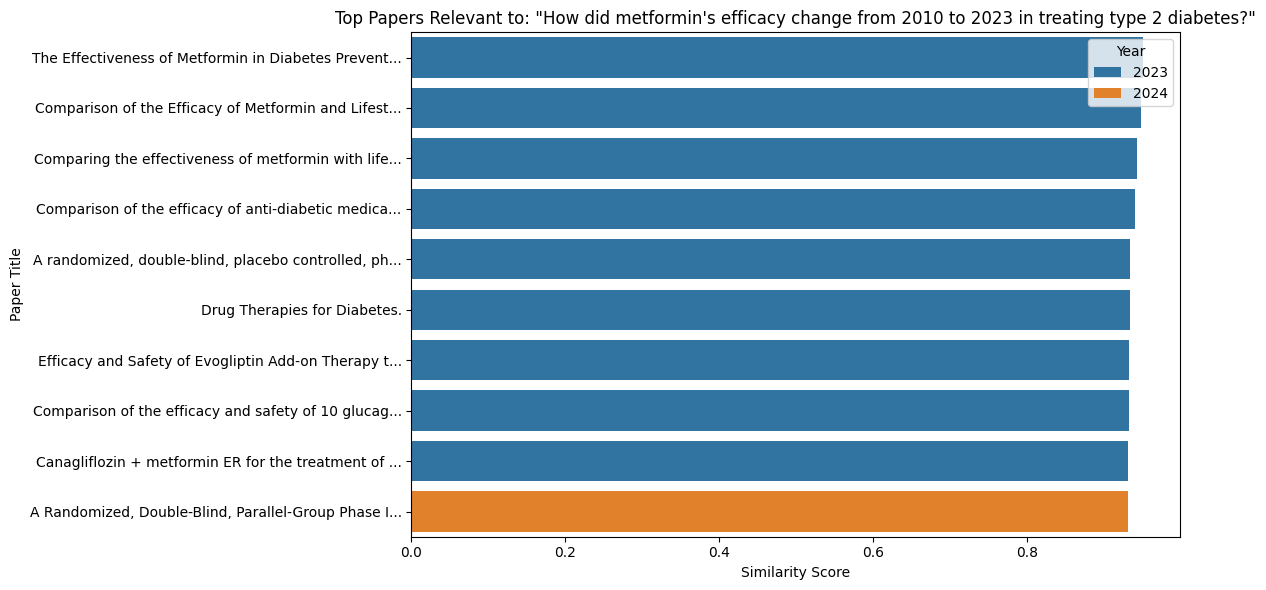

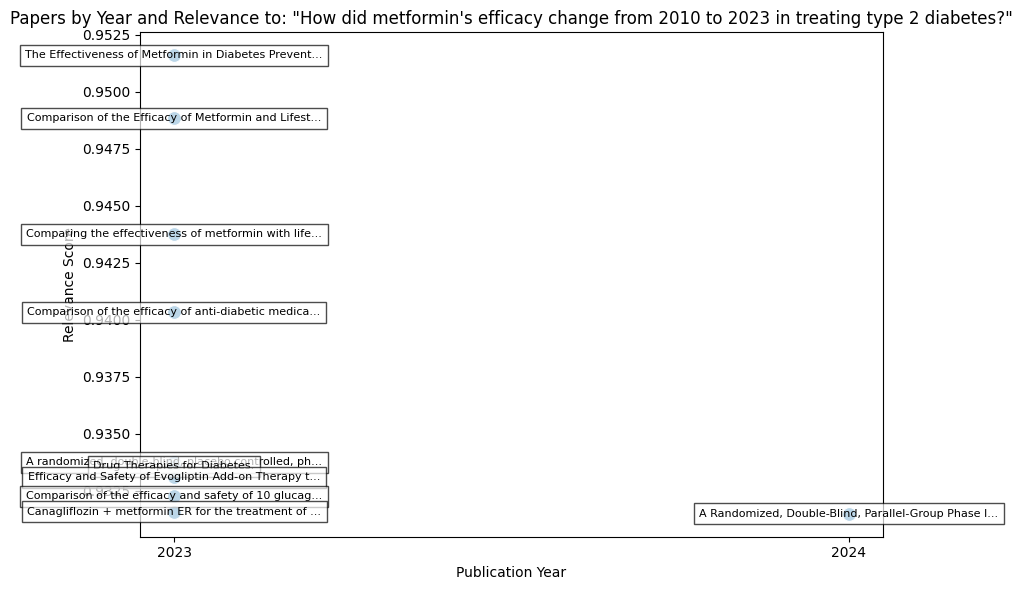


Top 10 papers with relevant passages:

Paper 1:



Paper 2:



Paper 3:


In [7]:
if papers:
    # Build the FAISS index
    bio_query_system.build_faiss_index(papers)

    # Retrieve the most relevant papers
    relevant_papers = bio_query_system.retrieve_relevant_passages(user_query, k=10)

    # Extract contextual passages
    contextual_passages = bio_query_system.extract_contextual_passages(relevant_papers, user_query)

    # Cell 9: Visualize results
    results_df = bio_query_system.visualize_results(relevant_papers, user_query)

    # Cell 10: Display details of the top papers
    print(f"\nTop {len(contextual_passages)} papers with relevant passages:")
    for i, paper in enumerate(contextual_passages[:3]):  # Show top 3 papers
        print(f"\nPaper {i+1}:")
        display_paper_details(paper)
else:
    print("No papers found. Try modifying your search query.")

### **Save results to JSON for later processing in Step 3**

In [8]:
if 'contextual_passages' in locals() and contextual_passages:
    with open('biomedical_passages.json', 'w') as f:
        # Convert the data structure to be JSON serializable
        serializable_passages = []
        for paper in contextual_passages:
            serializable_paper = {
                'pmid': paper['pmid'],
                'title': paper['title'],
                'abstract': paper['abstract'],
                'authors': paper['authors'],
                'publication_date': paper['publication_date'],
                'similarity_score': float(paper['similarity_score']),
                'passages': paper['passages']
            }
            serializable_passages.append(serializable_paper)

        json.dump(serializable_passages, f, indent=2)
    print(f"Saved {len(contextual_passages)} papers with passages to biomedical_passages.json")

    # Also save all papers for potential future use
    with open('all_papers.json', 'w') as f:
        # Convert the data structure to be JSON serializable
        serializable_papers = []
        for paper in papers:
            serializable_paper = {key: value for key, value in paper.items() if key != 'similarity_score'}
            serializable_papers.append(serializable_paper)

        json.dump(serializable_papers, f, indent=2)
    print(f"Saved all {len(papers)} papers to all_papers.json")

Saved 10 papers with passages to biomedical_passages.json
Saved all 49 papers to all_papers.json


### **Helper function to explore the distribution of publication years**

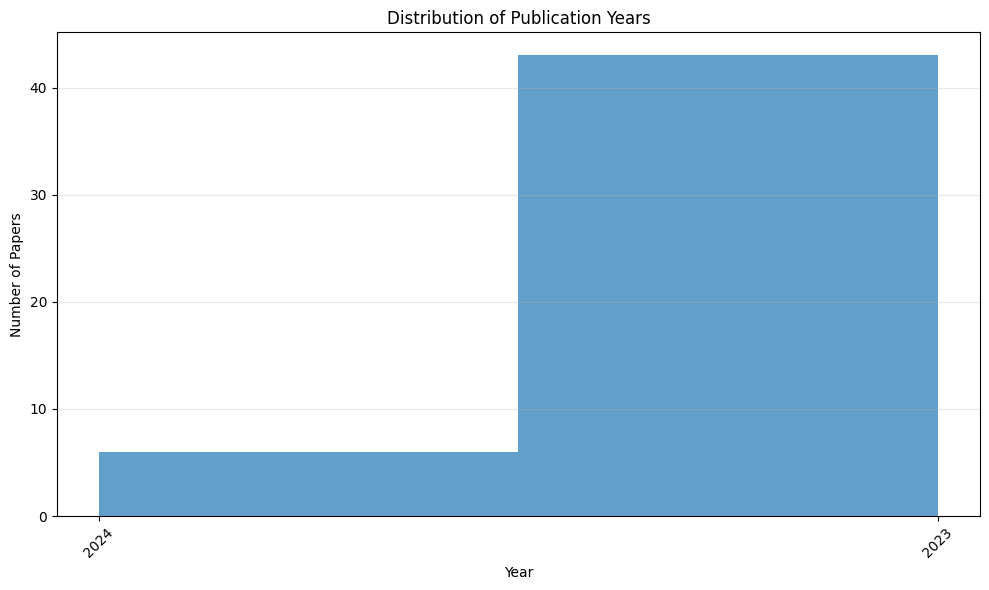

Papers per year:
2023    43
2024     6
Name: count, dtype: int64


In [9]:
if 'papers' in locals() and papers:
    years = [paper['publication_date'] for paper in papers if paper['publication_date']]

    plt.figure(figsize=(10, 6))
    plt.hist(years, bins=len(set(years)), alpha=0.7)
    plt.title('Distribution of Publication Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Count papers per year
    year_counts = pd.Series(years).value_counts().sort_index()
    print("Papers per year:")
    print(year_counts)